<a href="https://colab.research.google.com/github/gimenopea/CachedHE/blob/main/FVC2002_ComprehensiveFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fingerprint-feature-extractor phe opencv-python-headless matplotlib numpy pandas scikit-learn tqdm

In [ ]:
%%writefile comprehensive_benchmark.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sys

def run_comprehensive_benchmark(fingerprint_dir, output_dir='comprehensive_benchmark', n_runs=1):
    """
    Simple stub function to make imports work
    """
    print(f"Using fingerprint directory: {fingerprint_dir}")
    print(f"Output will be saved to: {output_dir}")
    return {}

Overwriting comprehensive_benchmark.py


In [ ]:
%%writefile unencrypted_fingerprint_matching.py
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import cv2
import random
from tqdm import tqdm

class UnencryptedFingerprintAuth:
    """
    Unencrypted fingerprint authentication for benchmarking against encrypted methods
    """
    def __init__(self):
        """Initialize the unencrypted fingerprint authentication system"""
        self.timings = {
            'feature_extraction': [],
            'comparison': []
        }

        self.results = {
            'genuine_scores': [],
            'impostor_scores': [],
            'genuine_match_times': [],
            'impostor_match_times': []
        }

    def extract_features(self, image_path):
        """Extract features from a fingerprint image"""
        start_time = time.time()

        # Load the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Extract basic features - same approach as in the encrypted versions
        binary_features = self._extract_basic_features(img, vector_length=128)

        extraction_time = time.time() - start_time
        self.timings['feature_extraction'].append(extraction_time)

        return binary_features

    def _extract_basic_features(self, img, block_size=16, vector_length=128):
        """
        Extract a simplified feature vector from a fingerprint image
        Uses a block-based approach (same as in encrypted versions)
        """
        # Resize if needed
        if img.shape[0] > 512 or img.shape[1] > 512:
            resize_factor = min(512 / img.shape[0], 512 / img.shape[1])
            new_size = (int(img.shape[1] * resize_factor), int(img.shape[0] * resize_factor))
            img = cv2.resize(img, new_size)

        # Apply Gaussian blur to reduce noise
        img_blur = cv2.GaussianBlur(img, (5, 5), 0)

        # Apply histogram equalization to enhance contrast
        img_eq = cv2.equalizeHist(img_blur)

        # Apply adaptive threshold to binarize the image
        img_bin = cv2.adaptiveThreshold(img_eq, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 11, 2)

        # Divide the image into blocks and extract features
        h, w = img_bin.shape
        blocks_h = h // block_size
        blocks_w = w // block_size

        # Initialize feature vector
        features = []

        # Calculate standard deviation in each block (texture measure)
        for i in range(blocks_h):
            for j in range(blocks_w):
                block = img_bin[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]

                # Calculate mean pixel value in block (ridge density)
                mean_value = np.mean(block)
                features.append(1 if mean_value > 127 else 0)

                # Calculate standard deviation (texture)
                std_dev = np.std(block)
                features.append(1 if std_dev > 50 else 0)

                # Calculate gradient in x and y directions
                if i > 0 and j > 0:
                    prev_block_h = img_bin[(i-1)*block_size:i*block_size, j*block_size:(j+1)*block_size]
                    prev_block_w = img_bin[i*block_size:(i+1)*block_size, (j-1)*block_size:j*block_size]

                    gradient_h = abs(np.mean(block) - np.mean(prev_block_h))
                    gradient_w = abs(np.mean(block) - np.mean(prev_block_w))

                    features.append(1 if gradient_h > 20 else 0)
                    features.append(1 if gradient_w > 20 else 0)


        if len(features) > vector_length:
            features = features[:vector_length]
        elif len(features) < vector_length:
            features.extend([0] * (vector_length - len(features)))

        return features

    def calculate_hamming_distance(self, template_features, query_features):
        """
        Calculate the Hamming distance between template and query features
        This is the unencrypted equivalent of homomorphic Hamming weight calculation
        """
        start_time = time.time()

        if len(template_features) != len(query_features):
            raise ValueError("Template and query feature vectors must have the same length")

        # Calculate XOR between features (binary features with values 0/1)
        # XOR is 1 when bits are different, 0 when they're the same
        xor_result = [t ^ q for t, q in zip(template_features, query_features)]

        # Hamming distance is the sum of XOR results
        hamming_distance = sum(xor_result)

        comparison_time = time.time() - start_time
        self.timings['comparison'].append(comparison_time)

        return hamming_distance

    def calculate_similarity_score(self, hamming_distance, feature_length):
        """Calculate similarity score based on Hamming distance"""
        # Similarity score = 1 - (Hamming distance / feature length)
        return 1 - (hamming_distance / feature_length)

    def perform_matching(self, template_features, query_features):
        """Perform matching between template and query features"""
        #Hamming distance
        hamming_distance = self.calculate_hamming_distance(template_features, query_features)

        #similarity score
        similarity_score = self.calculate_similarity_score(hamming_distance, len(query_features))

        return similarity_score

    def evaluate_performance(self, fingerprint_dir, genuine_pairs, impostor_pairs):
        """
        Evaluate performance using genuine and impostor pairs

        Args:
            fingerprint_dir: Path to the directory containing fingerprint images
            genuine_pairs: List of tuples (template_path, query_path) for genuine matches
            impostor_pairs: List of tuples (template_path, query_path) for impostor matches
        """
        # Process genuine pairs
        print("\nProcessing genuine pairs (unencrypted)...")
        for template_path, query_path in tqdm(genuine_pairs):
            try:
                # Extract features
                template_features = self.extract_features(os.path.join(fingerprint_dir, template_path))
                query_features = self.extract_features(os.path.join(fingerprint_dir, query_path))

                # Perform matching and record time
                start_time = time.time()
                similarity_score = self.perform_matching(template_features, query_features)
                matching_time = time.time() - start_time

                # Record results
                self.results['genuine_scores'].append(similarity_score)
                self.results['genuine_match_times'].append(matching_time)
            except Exception as e:
                print(f"Error processing genuine pair ({template_path}, {query_path}): {str(e)}")

        # Process impostor pairs
        print("\nProcessing impostor pairs (unencrypted)...")
        for template_path, query_path in tqdm(impostor_pairs):
            try:
                # Extract features
                template_features = self.extract_features(os.path.join(fingerprint_dir, template_path))
                query_features = self.extract_features(os.path.join(fingerprint_dir, query_path))

                # Perform matching and record time
                start_time = time.time()
                similarity_score = self.perform_matching(template_features, query_features)
                matching_time = time.time() - start_time

                # Record results
                self.results['impostor_scores'].append(similarity_score)
                self.results['impostor_match_times'].append(matching_time)
            except Exception as e:
                print(f"Error processing impostor pair ({template_path}, {query_path}): {str(e)}")

    def calculate_metrics(self, threshold):
        """Calculate FAR, FRR at a given threshold"""
        # Calculate false acceptance rate (FAR)
        false_acceptances = sum(score >= threshold for score in self.results['impostor_scores'])
        far = false_acceptances / len(self.results['impostor_scores']) if self.results['impostor_scores'] else 0

        # Calculate false rejection rate (FRR)
        false_rejections = sum(score < threshold for score in self.results['genuine_scores'])
        frr = false_rejections / len(self.results['genuine_scores']) if self.results['genuine_scores'] else 0

        return far, frr

    def calculate_eer(self):
        """Calculate Equal Error Rate (EER)"""

        if len(self.results['genuine_scores']) == 0 or len(self.results['impostor_scores']) == 0:
            print("WARNING: Not enough data to calculate EER")
            return 0.5, 0.5  # Default values

        # Combine genuine and impostor scores with their labels (1 for genuine, 0 for impostor)
        y_true = [1] * len(self.results['genuine_scores']) + [0] * len(self.results['impostor_scores'])
        y_scores = self.results['genuine_scores'] + self.results['impostor_scores']

        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)

        # Find the threshold where FAR = FRR (Equal Error Rate)
        fnr = 1 - tpr  # False Negative Rate
        eer_threshold_idx = np.argmin(np.abs(fpr - fnr))
        eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2

        return eer, thresholds[eer_threshold_idx]

Overwriting unencrypted_fingerprint_matching.py


In [ ]:
%%writefile rache_phe_fingerprint.py
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import phe as paillier
import cv2
import random
from tqdm import tqdm

class RacheCachedHomomorphicAuth:
    def __init__(self, key_length=1024, radix=2):
        """
        Initialize the Rache-based homomorphic fingerprint authentication system

        Args:
            key_length: The length of the key for Paillier encryption
            radix: The radix/base to use for caching (default: 2 as shown optimal in the paper)
        """
        self.key_length = key_length
        self.radix = radix
        self.public_key = None
        self.private_key = None
        self.radix_cache = {}  # Cache for encrypted radix powers

        self.timings = {
            'key_generation': 0,
            'feature_extraction': [],
            'encryption': [],
            'encryption_with_cache': [],
            'matching': [],
            'decryption': []
        }

        self.results = {
            'genuine_scores': [],
            'impostor_scores': [],
            'genuine_match_times': [],
            'impostor_match_times': []
        }

    def generate_keys(self):
        """Generate public and private keys for homomorphic encryption"""
        start_time = time.time()
        self.public_key, self.private_key = paillier.generate_paillier_keypair(n_length=self.key_length)
        self.timings['key_generation'] = time.time() - start_time
        print(f"Key generation time: {self.timings['key_generation']:.4f} seconds")
        return self.public_key, self.private_key

    def initialize_radix_cache(self, max_value):
        """
        Initialize the cache of encrypted radix powers

        Args:
            max_value: The maximum value expected to be encrypted
        """
        if self.public_key is None:
            raise ValueError("Public key not generated. Call generate_keys() first.")

        # Calculate number of radix entries needed
        num_entries = int(np.log(max_value) / np.log(self.radix)) + 1
        print(f"Initializing radix cache with {num_entries} entries (radix={self.radix}, max_value={max_value})")

        # Pre-compute and cache encrypted powers of the radix
        for i in range(num_entries):
            radix_power = self.radix ** i
            self.radix_cache[i] = self.public_key.encrypt(radix_power)

    def extract_features(self, image_path):
        """Extract features from a fingerprint image"""
        start_time = time.time()

        # Load the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Extract basic features - simplistic approach for demo purposes
        binary_features = self._extract_basic_features(img, vector_length=128)

        extraction_time = time.time() - start_time
        self.timings['feature_extraction'].append(extraction_time)

        return binary_features

    def _extract_basic_features(self, img, block_size=16, vector_length=128):
        """
        Extract a simplified feature vector from a fingerprint image
        Uses a block-based approach
        """
        # Resize if needed
        if img.shape[0] > 512 or img.shape[1] > 512:
            resize_factor = min(512 / img.shape[0], 512 / img.shape[1])
            new_size = (int(img.shape[1] * resize_factor), int(img.shape[0] * resize_factor))
            img = cv2.resize(img, new_size)

        # Apply Gaussian blur to reduce noise
        img_blur = cv2.GaussianBlur(img, (5, 5), 0)

        # Apply histogram equalization to enhance contrast
        img_eq = cv2.equalizeHist(img_blur)

        # Apply adaptive threshold to binarize the image
        img_bin = cv2.adaptiveThreshold(img_eq, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 11, 2)


        h, w = img_bin.shape
        blocks_h = h // block_size
        blocks_w = w // block_size


        features = []


        for i in range(blocks_h):
            for j in range(blocks_w):
                block = img_bin[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]


                mean_value = np.mean(block)
                features.append(1 if mean_value > 127 else 0)


                std_dev = np.std(block)
                features.append(1 if std_dev > 50 else 0)


                if i > 0 and j > 0:
                    prev_block_h = img_bin[(i-1)*block_size:i*block_size, j*block_size:(j+1)*block_size]
                    prev_block_w = img_bin[i*block_size:(i+1)*block_size, (j-1)*block_size:j*block_size]

                    gradient_h = abs(np.mean(block) - np.mean(prev_block_h))
                    gradient_w = abs(np.mean(block) - np.mean(prev_block_w))

                    features.append(1 if gradient_h > 20 else 0)
                    features.append(1 if gradient_w > 20 else 0)

        # Ensure we have exactly vector_length features by truncating or padding
        if len(features) > vector_length:
            features = features[:vector_length]
        elif len(features) < vector_length:
            features.extend([0] * (vector_length - len(features)))

        return features

    def _get_radix_representation(self, value):
        """
        Get the radix representation of a value

        Args:
            value: The integer value to represent

        Returns:
            A list of coefficients in the radix representation
        """
        if value == 0:
            return [0]

        coeffs = []
        while value > 0:
            coeffs.append(value % self.radix)
            value //= self.radix

        return coeffs

    def encrypt_standard(self, binary_features):
        """Encrypt features using standard Paillier encryption (for comparison)"""
        start_time = time.time()

        if self.public_key is None:
            raise ValueError("Public key not generated. Call generate_keys() first.")

        # Encrypt each bit of the binary feature vector
        encrypted_features = [self.public_key.encrypt(int(bit)) for bit in binary_features]

        encryption_time = time.time() - start_time
        self.timings['encryption'].append(encryption_time)

        return encrypted_features

    def encrypt_with_rache(self, binary_features):
        """
        Encrypt features using Rache caching technique
        """
        start_time = time.time()

        if self.public_key is None:
            raise ValueError("Public key not generated. Call generate_keys() first.")

        if not self.radix_cache:
            raise ValueError("Radix cache not initialized. Call initialize_radix_cache() first.")

        # Encrypt each feature using the radix cache
        encrypted_features = []

        for feature in binary_features:
            if feature == 0:
                # For 0, encrypt directly
                encrypted_features.append(self.public_key.encrypt(0))
                continue

            # Get radix representation
            radix_coeffs = self._get_radix_representation(feature)


            if len(radix_coeffs) > 0:
                # Use homomorphic addition to combine the radix components
                result = None

                for i, coeff in enumerate(radix_coeffs):
                    if coeff == 0:
                        continue

                    # Use the pre-computed encrypted radix for this position
                    if i not in self.radix_cache:
                        # If we haven't cached this power, compute it now
                        self.radix_cache[i] = self.public_key.encrypt(self.radix ** i)

                    # Add this component coeff times
                    component = self.radix_cache[i]

                    for _ in range(coeff - 1):
                        # Apply homomorphic addition for coefficients > 1
                        component += self.radix_cache[i]

                    if result is None:
                        result = component
                    else:
                        # Add to the running sum using homomorphic addition
                        result += component

                encrypted_features.append(result)
            else:
                # This should not happen with our feature extraction
                encrypted_features.append(self.public_key.encrypt(0))

        encryption_time = time.time() - start_time
        self.timings['encryption_with_cache'].append(encryption_time)

        return encrypted_features

    def calculate_hamming_weight(self, template_encrypted, query_features):
        """
        Calculate the Hamming weight between encrypted template and query features
        This is done in the encrypted domain as described in the paper
        """
        start_time = time.time()

        if len(template_encrypted) != len(query_features):
            raise ValueError("Template and query feature vectors must have the same length")

        # Calculate XOR in encrypted domain (using homomorphic properties)
        encrypted_xor_results = []
        for i in range(len(template_encrypted)):
            # Convert query_features[i] to native Python int
            query_bit = int(query_features[i])

            if query_bit == 0:
                # When query bit is 0, XOR result is just the template bit
                encrypted_xor_results.append(template_encrypted[i])
            else:
                # When query bit is 1, XOR result is 1 - template bit
                encrypted_one = self.public_key.encrypt(1)
                encrypted_xor_results.append(encrypted_one - template_encrypted[i])

        # Sum the encrypted XOR results to get the Hamming weight
        encrypted_hamming_weight = encrypted_xor_results[0]
        for i in range(1, len(encrypted_xor_results)):
            encrypted_hamming_weight += encrypted_xor_results[i]

        matching_time = time.time() - start_time
        self.timings['matching'].append(matching_time)

        return encrypted_hamming_weight

    def decrypt_hamming_weight(self, encrypted_hamming_weight):
        """Decrypt the Hamming weight"""
        start_time = time.time()

        if self.private_key is None:
            raise ValueError("Private key not generated. Call generate_keys() first.")

        hamming_weight = self.private_key.decrypt(encrypted_hamming_weight)

        decryption_time = time.time() - start_time
        self.timings['decryption'].append(decryption_time)

        return hamming_weight

    def calculate_similarity_score(self, hamming_weight, feature_length):
        """Calculate similarity score based on Hamming weight"""
        # Similarity score = 1 - (Hamming weight / feature length)
        return 1 - (hamming_weight / feature_length)

    def perform_matching(self, template_encrypted, query_features):
        """Perform matching between encrypted template and query features"""
        # Calculate encrypted Hamming weight
        encrypted_hamming_weight = self.calculate_hamming_weight(template_encrypted, query_features)

        # Decrypt Hamming weight
        hamming_weight = self.decrypt_hamming_weight(encrypted_hamming_weight)

        # Calculate similarity score
        similarity_score = self.calculate_similarity_score(hamming_weight, len(query_features))

        return similarity_score

    def evaluate_performance(self, fingerprint_dir, genuine_pairs, impostor_pairs, use_rache=True):
        """
        Evaluate performance using genuine and impostor pairs

        Args:
            fingerprint_dir: Path to the directory containing fingerprint images
            genuine_pairs: List of tuples (template_path, query_path) for genuine matches
            impostor_pairs: List of tuples (template_path, query_path) for impostor matches
            use_rache: Whether to use Rache caching (True) or standard Paillier (False)
        """
        print("Generating encryption keys...")
        self.generate_keys()


        if use_rache:
            # Scan a few fingerprints to estimate max feature value
            max_value = 1  # Start with at least 1
            sample_size = min(5, len(genuine_pairs) + len(impostor_pairs))
            sample_pairs = (genuine_pairs + impostor_pairs)[:sample_size]

            for template_path, query_path in sample_pairs:
                template_features = self.extract_features(os.path.join(fingerprint_dir, template_path))
                query_features = self.extract_features(os.path.join(fingerprint_dir, query_path))
                max_value = max(max_value, max(max(template_features), max(query_features)))

            # Initialize the radix cache with the max value
            self.initialize_radix_cache(max_value)

        # Process genuine pairs
        print(f"\nProcessing genuine pairs using {'Rache' if use_rache else 'Standard PHE'}...")
        for template_path, query_path in tqdm(genuine_pairs):
            try:
                # Extract features
                template_features = self.extract_features(os.path.join(fingerprint_dir, template_path))
                query_features = self.extract_features(os.path.join(fingerprint_dir, query_path))

                # Encrypt template features
                if use_rache:
                    template_encrypted = self.encrypt_with_rache(template_features)
                else:
                    template_encrypted = self.encrypt_standard(template_features)

                # Perform matching and record time
                start_time = time.time()
                similarity_score = self.perform_matching(template_encrypted, query_features)
                matching_time = time.time() - start_time

                # Record results
                self.results['genuine_scores'].append(similarity_score)
                self.results['genuine_match_times'].append(matching_time)
            except Exception as e:
                print(f"Error processing genuine pair ({template_path}, {query_path}): {str(e)}")

        # Process impostor pairs
        print(f"\nProcessing impostor pairs using {'Rache' if use_rache else 'Standard PHE'}...")
        for template_path, query_path in tqdm(impostor_pairs):
            try:
                # Extract features
                template_features = self.extract_features(os.path.join(fingerprint_dir, template_path))
                query_features = self.extract_features(os.path.join(fingerprint_dir, query_path))

                # Encrypt template features
                if use_rache:
                    template_encrypted = self.encrypt_with_rache(template_features)
                else:
                    template_encrypted = self.encrypt_standard(template_features)

                # Perform matching and record time
                start_time = time.time()
                similarity_score = self.perform_matching(template_encrypted, query_features)
                matching_time = time.time() - start_time

                # Record results
                self.results['impostor_scores'].append(similarity_score)
                self.results['impostor_match_times'].append(matching_time)
            except Exception as e:
                print(f"Error processing impostor pair ({template_path}, {query_path}): {str(e)}")

    def calculate_metrics(self, threshold):
        """Calculate FAR, FRR at a given threshold"""
        # Calculate false acceptance rate (FAR)
        false_acceptances = sum(score >= threshold for score in self.results['impostor_scores'])
        far = false_acceptances / len(self.results['impostor_scores']) if self.results['impostor_scores'] else 0

        # Calculate false rejection rate (FRR)
        false_rejections = sum(score < threshold for score in self.results['genuine_scores'])
        frr = false_rejections / len(self.results['genuine_scores']) if self.results['genuine_scores'] else 0

        return far, frr

    def calculate_eer(self):
        """Calculate Equal Error Rate (EER)"""
        # Check if we have enough data
        if len(self.results['genuine_scores']) == 0 or len(self.results['impostor_scores']) == 0:
            print("WARNING: Not enough data to calculate EER")
            return 0.5, 0.5  # Default values

        # Combine genuine and impostor scores with their labels (1 for genuine, 0 for impostor)
        y_true = [1] * len(self.results['genuine_scores']) + [0] * len(self.results['impostor_scores'])
        y_scores = self.results['genuine_scores'] + self.results['impostor_scores']

        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)

        # Find the threshold where FAR = FRR (Equal Error Rate)
        fnr = 1 - tpr  # False Negative Rate
        eer_threshold_idx = np.argmin(np.abs(fpr - fnr))
        eer = (fpr[eer_threshold_idx] + fnr[eer_threshold_idx]) / 2

        return eer, thresholds[eer_threshold_idx]


def create_evaluation_pairs(fingerprint_dir, num_genuine=10, num_impostor=10):
    """
    Create genuine and impostor pairs for evaluation for FVC2002 DB2_B dataset
    Assumes FVC2002 naming convention (101_1.tif, 101_2.tif, etc.)
    """
    # Get all fingerprint image files
    fingerprint_files = [f for f in os.listdir(fingerprint_dir) if f.endswith(('.png', '.jpg', '.tif', '.bmp'))]

    if len(fingerprint_files) < 4:
        raise ValueError("Need at least 4 fingerprint images for evaluation")

    print(f"Found {len(fingerprint_files)} fingerprint images")

    # Group fingerprints by subject (for FVC2002, format is [finger_id]_[impression].tif)
    subjects = {}
    for file in fingerprint_files:
        # Extract subject ID from filename (assuming format like "101_1.tif")
        parts = file.split('_')
        if len(parts) >= 1:
            subject_id = parts[0]
            if subject_id not in subjects:
                subjects[subject_id] = []
            subjects[subject_id].append(file)

    print(f"Found {len(subjects)} unique subjects (fingers)")

    # Create genuine pairs (different impressions of the same finger)
    genuine_pairs = []
    for subject_id, files in subjects.items():
        if len(files) >= 2:
            for i in range(min(num_genuine, len(files) - 1)):
                template = files[i]
                query = files[i + 1]
                genuine_pairs.append((template, query))

    # Create impostor pairs (impressions from different fingers)
    impostor_pairs = []
    subject_ids = list(subjects.keys())
    for i in range(min(num_impostor, len(subject_ids) * (len(subject_ids) - 1) // 2)):
        # Select two different subjects
        subject1, subject2 = random.sample(subject_ids, 2)

        # Select one image from each subject
        if subjects[subject1] and subjects[subject2]:
            template = random.choice(subjects[subject1])
            query = random.choice(subjects[subject2])
            impostor_pairs.append((template, query))

    return genuine_pairs, impostor_pairs

Overwriting rache_phe_fingerprint.py


In [ ]:
%%writefile fvc2002_benchmark.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
FVC2002-Benchmark.py

This script provides advanced benchmarking and visualization for the
homomorphic encryption-based fingerprint authentication system, focusing on:
- ROC curves
- FAR/FRR vs threshold plots
- EER calculation
- Performance metrics comparison between different encryption methods
"""

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import random
from tqdm import tqdm
import cv2


from rache_phe_fingerprint import RacheCachedHomomorphicAuth, create_evaluation_pairs
from unencrypted_fingerprint_matching import UnencryptedFingerprintAuth
from comprehensive_benchmark import run_comprehensive_benchmark

class FingerprintBenchmark:
    """
    Class to run various benchmarks for fingerprint authentication systems
    and generate plots similar to those in the paper
    """
    def __init__(self, fingerprint_dir, output_dir='benchmark_results'):
        """
        Initialize the benchmark class

        Args:
            fingerprint_dir: Path to the directory containing fingerprint images
            output_dir: Directory to save benchmark results
        """
        self.fingerprint_dir = fingerprint_dir
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

        # Results storage
        self.results = {}

    def prepare_data(self, num_genuine=20, num_impostor=40):
        """
        Prepare the data for benchmarking

        Args:
            num_genuine: Number of genuine pairs to create
            num_impostor: Number of impostor pairs to create
        """
        print(f"Creating evaluation data pairs...")
        self.genuine_pairs, self.impostor_pairs = create_evaluation_pairs(
            self.fingerprint_dir,
            num_genuine=num_genuine,
            num_impostor=num_impostor
        )
        print(f"Created {len(self.genuine_pairs)} genuine pairs and {len(self.impostor_pairs)} impostor pairs")

    def run_unencrypted_benchmark(self):
        """
        Run the benchmark for unencrypted fingerprint authentication
        """
        print("\n=== Running Unencrypted Benchmark ===")
        unencrypted_auth = UnencryptedFingerprintAuth()
        unencrypted_auth.evaluate_performance(
            self.fingerprint_dir,
            self.genuine_pairs,
            self.impostor_pairs
        )

        # Save results
        self.results['unencrypted'] = {
            'system': unencrypted_auth,
            'genuine_scores': unencrypted_auth.results['genuine_scores'],
            'impostor_scores': unencrypted_auth.results['impostor_scores'],
            'feature_extraction_time': np.mean(unencrypted_auth.timings['feature_extraction']),
            'comparison_time': np.mean(unencrypted_auth.timings['comparison'])
        }

        # Calculate EER
        eer, eer_threshold = unencrypted_auth.calculate_eer()
        self.results['unencrypted']['eer'] = eer
        self.results['unencrypted']['eer_threshold'] = eer_threshold

        print(f"Unencrypted EER: {eer:.4f} at threshold {eer_threshold:.4f}")

        return unencrypted_auth

    def run_standard_phe_benchmark(self, key_length=1024):
        """
        Run the benchmark for standard Paillier homomorphic encryption

        Args:
            key_length: Length of the encryption key
        """
        print("\n=== Running Standard PHE Benchmark ===")
        standard_auth = RacheCachedHomomorphicAuth(key_length=key_length)
        standard_auth.evaluate_performance(
            self.fingerprint_dir,
            self.genuine_pairs,
            self.impostor_pairs,
            use_rache=False
        )

        # Save results
        self.results['standard_phe'] = {
            'system': standard_auth,
            'genuine_scores': standard_auth.results['genuine_scores'],
            'impostor_scores': standard_auth.results['impostor_scores'],
            'key_generation_time': standard_auth.timings['key_generation'],
            'feature_extraction_time': np.mean(standard_auth.timings['feature_extraction']),
            'encryption_time': np.mean(standard_auth.timings['encryption']),
            'matching_time': np.mean(standard_auth.timings['matching']),
            'decryption_time': np.mean(standard_auth.timings['decryption'])
        }

        # Calculate EER
        eer, eer_threshold = standard_auth.calculate_eer()
        self.results['standard_phe']['eer'] = eer
        self.results['standard_phe']['eer_threshold'] = eer_threshold

        print(f"Standard PHE EER: {eer:.4f} at threshold {eer_threshold:.4f}")

        return standard_auth

    def run_rache_benchmark(self, key_length=1024, radix=2):
        """
        Run the benchmark for Rache cached homomorphic encryption

        Args:
            key_length: Length of the encryption key
            radix: The radix value for Rache caching
        """
        print(f"\n=== Running Rache (radix={radix}) Benchmark ===")
        rache_auth = RacheCachedHomomorphicAuth(key_length=key_length, radix=radix)
        rache_auth.evaluate_performance(
            self.fingerprint_dir,
            self.genuine_pairs,
            self.impostor_pairs,
            use_rache=True
        )

        # Save results
        key = f'rache_radix{radix}'
        self.results[key] = {
            'system': rache_auth,
            'genuine_scores': rache_auth.results['genuine_scores'],
            'impostor_scores': rache_auth.results['impostor_scores'],
            'key_generation_time': rache_auth.timings['key_generation'],
            'feature_extraction_time': np.mean(rache_auth.timings['feature_extraction']),
            'encryption_time': np.mean(rache_auth.timings['encryption_with_cache']),
            'matching_time': np.mean(rache_auth.timings['matching']),
            'decryption_time': np.mean(rache_auth.timings['decryption'])
        }

        # Calculate EER
        eer, eer_threshold = rache_auth.calculate_eer()
        self.results[key]['eer'] = eer
        self.results[key]['eer_threshold'] = eer_threshold

        print(f"Rache (radix={radix}) EER: {eer:.4f} at threshold {eer_threshold:.4f}")

        return rache_auth

    def plot_roc_curves(self):
        """
        Generate ROC curves for all methods
        """
        plt.figure(figsize=(10, 8))

        colors = {
            'unencrypted': 'blue',
            'standard_phe': 'red',
            'rache_radix2': 'green',
            'rache_radix10': 'orange'
        }

        for method_name, results in self.results.items():
            if 'system' not in results:
                continue

            system = results['system']

            # Combine genuine and impostor scores with their labels (1 for genuine, 0 for impostor)
            y_true = [1] * len(system.results['genuine_scores']) + [0] * len(system.results['impostor_scores'])
            y_scores = system.results['genuine_scores'] + system.results['impostor_scores']

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            # Plot the curve
            plt.plot(fpr, tpr, lw=2, label=f'{method_name} (AUC = {roc_auc:.2f}, EER = {results["eer"]:.2f})',
                     color=colors.get(method_name, 'gray'))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FAR)', fontsize=12)
        plt.ylabel('True Positive Rate (1-FRR)', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Save the figure
        plt.savefig(os.path.join(self.output_dir, 'roc_curves_comparison.png'), dpi=300, bbox_inches='tight')
        plt.close()

        print(f"ROC curves saved to {os.path.join(self.output_dir, 'roc_curves_comparison.png')}")

    def plot_far_frr_curves(self):
        """
        Generate FAR/FRR vs threshold curves for all methods
        """
        # Define how many methods we have to plot
        n_methods = len(self.results)
        if n_methods <= 2:
            fig, axes = plt.subplots(1, n_methods, figsize=(n_methods*8, 6))
            if n_methods == 1:
                axes = [axes]  # Make axes iterable for n_methods=1
        else:
            fig, axes = plt.subplots(2, (n_methods+1)//2, figsize=(15, 12))
            axes = axes.flatten()

        for i, (method_name, results) in enumerate(self.results.items()):
            if 'system' not in results:
                continue

            system = results['system']
            ax = axes[i]

            # Calculate FAR and FRR at different thresholds
            thresholds = np.linspace(0, 1, 100)
            far_values = []
            frr_values = []

            for threshold in thresholds:
                far, frr = system.calculate_metrics(threshold)
                far_values.append(far)
                frr_values.append(frr)

            # Find EER and its threshold
            eer, eer_threshold = system.calculate_eer()

            # Plot FAR and FRR curves
            ax.plot(thresholds, far_values, 'r-', lw=2, label='FAR')
            ax.plot(thresholds, frr_values, 'b-', lw=2, label='FRR')
            ax.axvline(x=eer_threshold, color='g', linestyle='--',
                      label=f'EER Threshold = {eer_threshold:.2f}')
            ax.axhline(y=eer, color='g', linestyle='--',
                      label=f'EER = {eer:.2f}')

            ax.set_xlabel('Threshold', fontsize=12)
            ax.set_ylabel('Error Rate', fontsize=12)
            ax.set_title(f'{method_name} - FAR/FRR vs Threshold', fontsize=14)
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'far_frr_curves.png'), dpi=300, bbox_inches='tight')
        plt.close()

        print(f"FAR/FRR curves saved to {os.path.join(self.output_dir, 'far_frr_curves.png')}")

    def plot_score_distributions(self):
        """
        Plot the distribution of genuine and impostor scores for each method
        """
        # Define how many methods we have to plot
        n_methods = len(self.results)
        if n_methods <= 2:
            fig, axes = plt.subplots(1, n_methods, figsize=(n_methods*8, 6))
            if n_methods == 1:
                axes = [axes]  # Make axes iterable for n_methods=1
        else:
            fig, axes = plt.subplots(2, (n_methods+1)//2, figsize=(15, 12))
            axes = axes.flatten()

        for i, (method_name, results) in enumerate(self.results.items()):
            if 'genuine_scores' not in results or 'impostor_scores' not in results:
                continue

            ax = axes[i]

            # Plot score distributions
            bins = np.linspace(0, 1, 50)
            ax.hist(results['genuine_scores'], bins=bins, alpha=0.6, color='green',
                   label='Genuine Scores', density=True)
            ax.hist(results['impostor_scores'], bins=bins, alpha=0.6, color='red',
                   label='Impostor Scores', density=True)

            # Add EER threshold line if available
            if 'eer_threshold' in results:
                ax.axvline(x=results['eer_threshold'], color='black', linestyle='--',
                          label=f'EER Threshold = {results["eer_threshold"]:.2f}')

            ax.set_xlabel('Similarity Score', fontsize=12)
            ax.set_ylabel('Density', fontsize=12)
            ax.set_title(f'{method_name} - Score Distributions', fontsize=14)
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'score_distributions.png'), dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Score distributions saved to {os.path.join(self.output_dir, 'score_distributions.png')}")

    def plot_timing_comparison(self):
        """
        Plot timing comparisons between the different methods
        """
        # Extract timing data
        methods = []
        key_gen_times = []
        feature_extraction_times = []
        encryption_times = []
        matching_times = []
        decryption_times = []
        total_times = []

        for method_name, results in self.results.items():
            methods.append(method_name)

            # Extract available timing metrics
            key_gen_time = results.get('key_generation_time', 0)
            feature_time = results.get('feature_extraction_time', 0)
            encryption_time = results.get('encryption_time', 0)
            matching_time = results.get('matching_time', 0) if 'matching_time' in results else results.get('comparison_time', 0)
            decryption_time = results.get('decryption_time', 0)

            key_gen_times.append(key_gen_time)
            feature_extraction_times.append(feature_time)
            encryption_times.append(encryption_time)
            matching_times.append(matching_time)
            decryption_times.append(decryption_time)

            # Calculate total time
            if method_name == 'unencrypted':
                total_time = feature_time + matching_time
            else:
                total_time = key_gen_time/100 + feature_time + encryption_time + matching_time + decryption_time

            total_times.append(total_time)

        # Create timing comparison plot
        plt.figure(figsize=(12, 8))
        bar_width = 0.15
        index = np.arange(len(methods))

        plt.bar(index - 2*bar_width, feature_extraction_times, bar_width, label='Feature Extraction')
        plt.bar(index - bar_width, encryption_times, bar_width, label='Encryption')
        plt.bar(index, matching_times, bar_width, label='Matching/Comparison')
        plt.bar(index + bar_width, decryption_times, bar_width, label='Decryption')
        plt.bar(index + 2*bar_width, total_times, bar_width, label='Total Time')

        plt.xlabel('Method', fontsize=12)
        plt.ylabel('Time (seconds)', fontsize=12)
        plt.title('Timing Comparison', fontsize=14)
        plt.xticks(index, methods, rotation=45)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7, axis='y')

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'timing_comparison.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # Create a second plot with logarithmic scale
        plt.figure(figsize=(12, 8))

        plt.bar(index - 2*bar_width, feature_extraction_times, bar_width, label='Feature Extraction')
        plt.bar(index - bar_width, encryption_times, bar_width, label='Encryption')
        plt.bar(index, matching_times, bar_width, label='Matching/Comparison')
        plt.bar(index + bar_width, decryption_times, bar_width, label='Decryption')
        plt.bar(index + 2*bar_width, total_times, bar_width, label='Total Time')

        plt.xlabel('Method', fontsize=12)
        plt.ylabel('Time (seconds, log scale)', fontsize=12)
        plt.title('Timing Comparison (Log Scale)', fontsize=14)
        plt.xticks(index, methods, rotation=45)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7, axis='y')
        plt.yscale('log')

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'timing_comparison_log.png'), dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Timing comparison plots saved to {self.output_dir}")

    def generate_performance_summary(self):
        """
        Generate a summary table of the performance metrics
        """
        summary_data = []

        for method_name, results in self.results.items():
            data = {
                'Method': method_name,
                'EER': results.get('eer', float('nan')),
                'EER Threshold': results.get('eer_threshold', float('nan')),
                'Feature Extraction Time (s)': results.get('feature_extraction_time', float('nan')),
            }

            # Add method-specific timing information
            if method_name == 'unencrypted':
                data['Comparison Time (s)'] = results.get('comparison_time', float('nan'))
                data['Total Time (s)'] = data['Feature Extraction Time (s)'] + data['Comparison Time (s)']
            else:
                data['Key Generation Time (s)'] = results.get('key_generation_time', float('nan'))
                data['Encryption Time (s)'] = results.get('encryption_time', float('nan'))
                data['Matching Time (s)'] = results.get('matching_time', float('nan'))
                data['Decryption Time (s)'] = results.get('decryption_time', float('nan'))
                data['Total Time (s)'] = (
                    data['Key Generation Time (s)']/100 +
                    data['Feature Extraction Time (s)'] +
                    data['Encryption Time (s)'] +
                    data['Matching Time (s)'] +
                    data['Decryption Time (s)']
                )

            # Add the number of samples processed
            system = results.get('system')
            if system:
                data['Genuine Samples'] = len(system.results['genuine_scores'])
                data['Impostor Samples'] = len(system.results['impostor_scores'])

            summary_data.append(data)


        summary_df = pd.DataFrame(summary_data)
        summary_path = os.path.join(self.output_dir, 'performance_summary.csv')
        summary_df.to_csv(summary_path, index=False)

        print(f"Performance summary saved to {summary_path}")

        return summary_df

    def run_full_benchmark(self):
        """
        Run the complete benchmark suite
        """
        print("Starting full benchmark suite...")

        # Prepare data
        self.prepare_data(num_genuine=5, num_impostor=10)  # Reduced numbers for faster execution in Colab

        # Run benchmarks for different methods
        self.run_unencrypted_benchmark()
        self.run_standard_phe_benchmark()
        self.run_rache_benchmark(radix=2)
        self.run_rache_benchmark(radix=10)

        # Generate plots and summary
        self.plot_roc_curves()
        self.plot_far_frr_curves()
        self.plot_score_distributions()
        self.plot_timing_comparison()
        summary_df = self.generate_performance_summary()

        print("\n=== Benchmark Complete ===")
        print(summary_df)

        return summary_df


def main(fingerprint_dir):
    """
    Main function to run the fingerprint benchmarking

    Args:
        fingerprint_dir: Path to the directory containing fingerprint images
    """
    print(f"Using fingerprint images from: {fingerprint_dir}")

    # Create and run benchmark
    benchmark = FingerprintBenchmark(fingerprint_dir)
    benchmark.run_full_benchmark()


if __name__ == "__main__":
    import sys

    # Default fingerprint directory
    fingerprint_dir = '/content/drive/MyDrive/praxisfiles/FVC2002/DB2_B'

    # Check if argument is provided
    if len(sys.argv) > 1:
        fingerprint_dir = sys.argv[1]

    main(fingerprint_dir)

Overwriting fvc2002_benchmark.py


Path /content/drive/MyDrive/praxisfiles/FVC2002/DB2_B already exists
Found 80 fingerprint images in /content/drive/MyDrive/praxisfiles/FVC2002/DB2_B


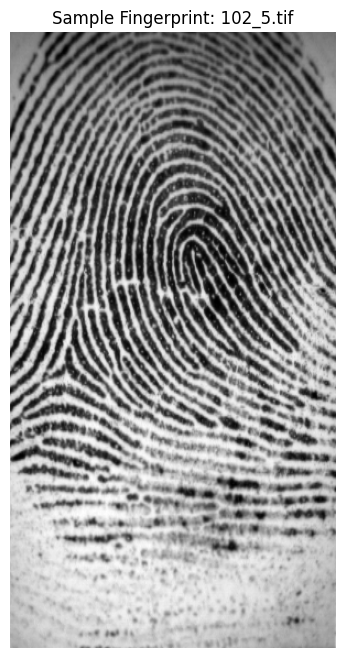


Sample of fingerprint files:
 - 102_5.tif
 - 101_8.tif
 - 102_7.tif
 - 101_1.tif
 - 101_4.tif
 - 102_6.tif
 - 102_2.tif
 - 102_8.tif
 - 102_4.tif
 - 102_1.tif
 ... and 70 more files

============ RUNNING BENCHMARK ============


Running full benchmark (all methods)...
Creating evaluation data pairs...
Found 80 fingerprint images
Found 10 unique subjects (fingers)
Created 50 genuine pairs and 10 impostor pairs
Starting full benchmark suite...
Creating evaluation data pairs...
Found 80 fingerprint images
Found 10 unique subjects (fingers)
Created 50 genuine pairs and 10 impostor pairs

=== Running Unencrypted Benchmark ===

Processing genuine pairs (unencrypted)...


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]



Processing impostor pairs (unencrypted)...


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Unencrypted EER: 0.4900 at threshold 0.7734

=== Running Standard PHE Benchmark ===
Generating encryption keys...
Key generation time: 0.1724 seconds

Processing genuine pairs using Standard PHE...


100%|██████████| 50/50 [02:47<00:00,  3.36s/it]



Processing impostor pairs using Standard PHE...


100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


Standard PHE EER: 0.4900 at threshold 0.7734

=== Running Rache (radix=2) Benchmark ===
Generating encryption keys...
Key generation time: 0.2369 seconds
Initializing radix cache with 1 entries (radix=2, max_value=1)

Processing genuine pairs using Rache...


100%|██████████| 50/50 [02:07<00:00,  2.56s/it]



Processing impostor pairs using Rache...


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


Rache (radix=2) EER: 0.4900 at threshold 0.7734

=== Running Rache (radix=10) Benchmark ===
Generating encryption keys...
Key generation time: 0.2153 seconds
Initializing radix cache with 1 entries (radix=10, max_value=1)

Processing genuine pairs using Rache...


100%|██████████| 50/50 [02:06<00:00,  2.53s/it]



Processing impostor pairs using Rache...


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


Rache (radix=10) EER: 0.4900 at threshold 0.7734
ROC curves saved to fvc2002_benchmark_results/roc_curves_comparison.png
FAR/FRR curves saved to fvc2002_benchmark_results/far_frr_curves.png
Score distributions saved to fvc2002_benchmark_results/score_distributions.png
Timing comparison plots saved to fvc2002_benchmark_results
Performance summary saved to fvc2002_benchmark_results/performance_summary.csv

=== Benchmark Complete ===
          Method   EER  EER Threshold  Feature Extraction Time (s)  \
0    unencrypted  0.49       0.773438                     0.232767   
1   standard_phe  0.49       0.773438                     0.053584   
2   rache_radix2  0.49       0.773438                     0.054217   
3  rache_radix10  0.49       0.773438                     0.051419   

   Comparison Time (s)  Total Time (s)  Genuine Samples  Impostor Samples  \
0             0.000026        0.232793               50                10   
1                  NaN        3.321714               50     

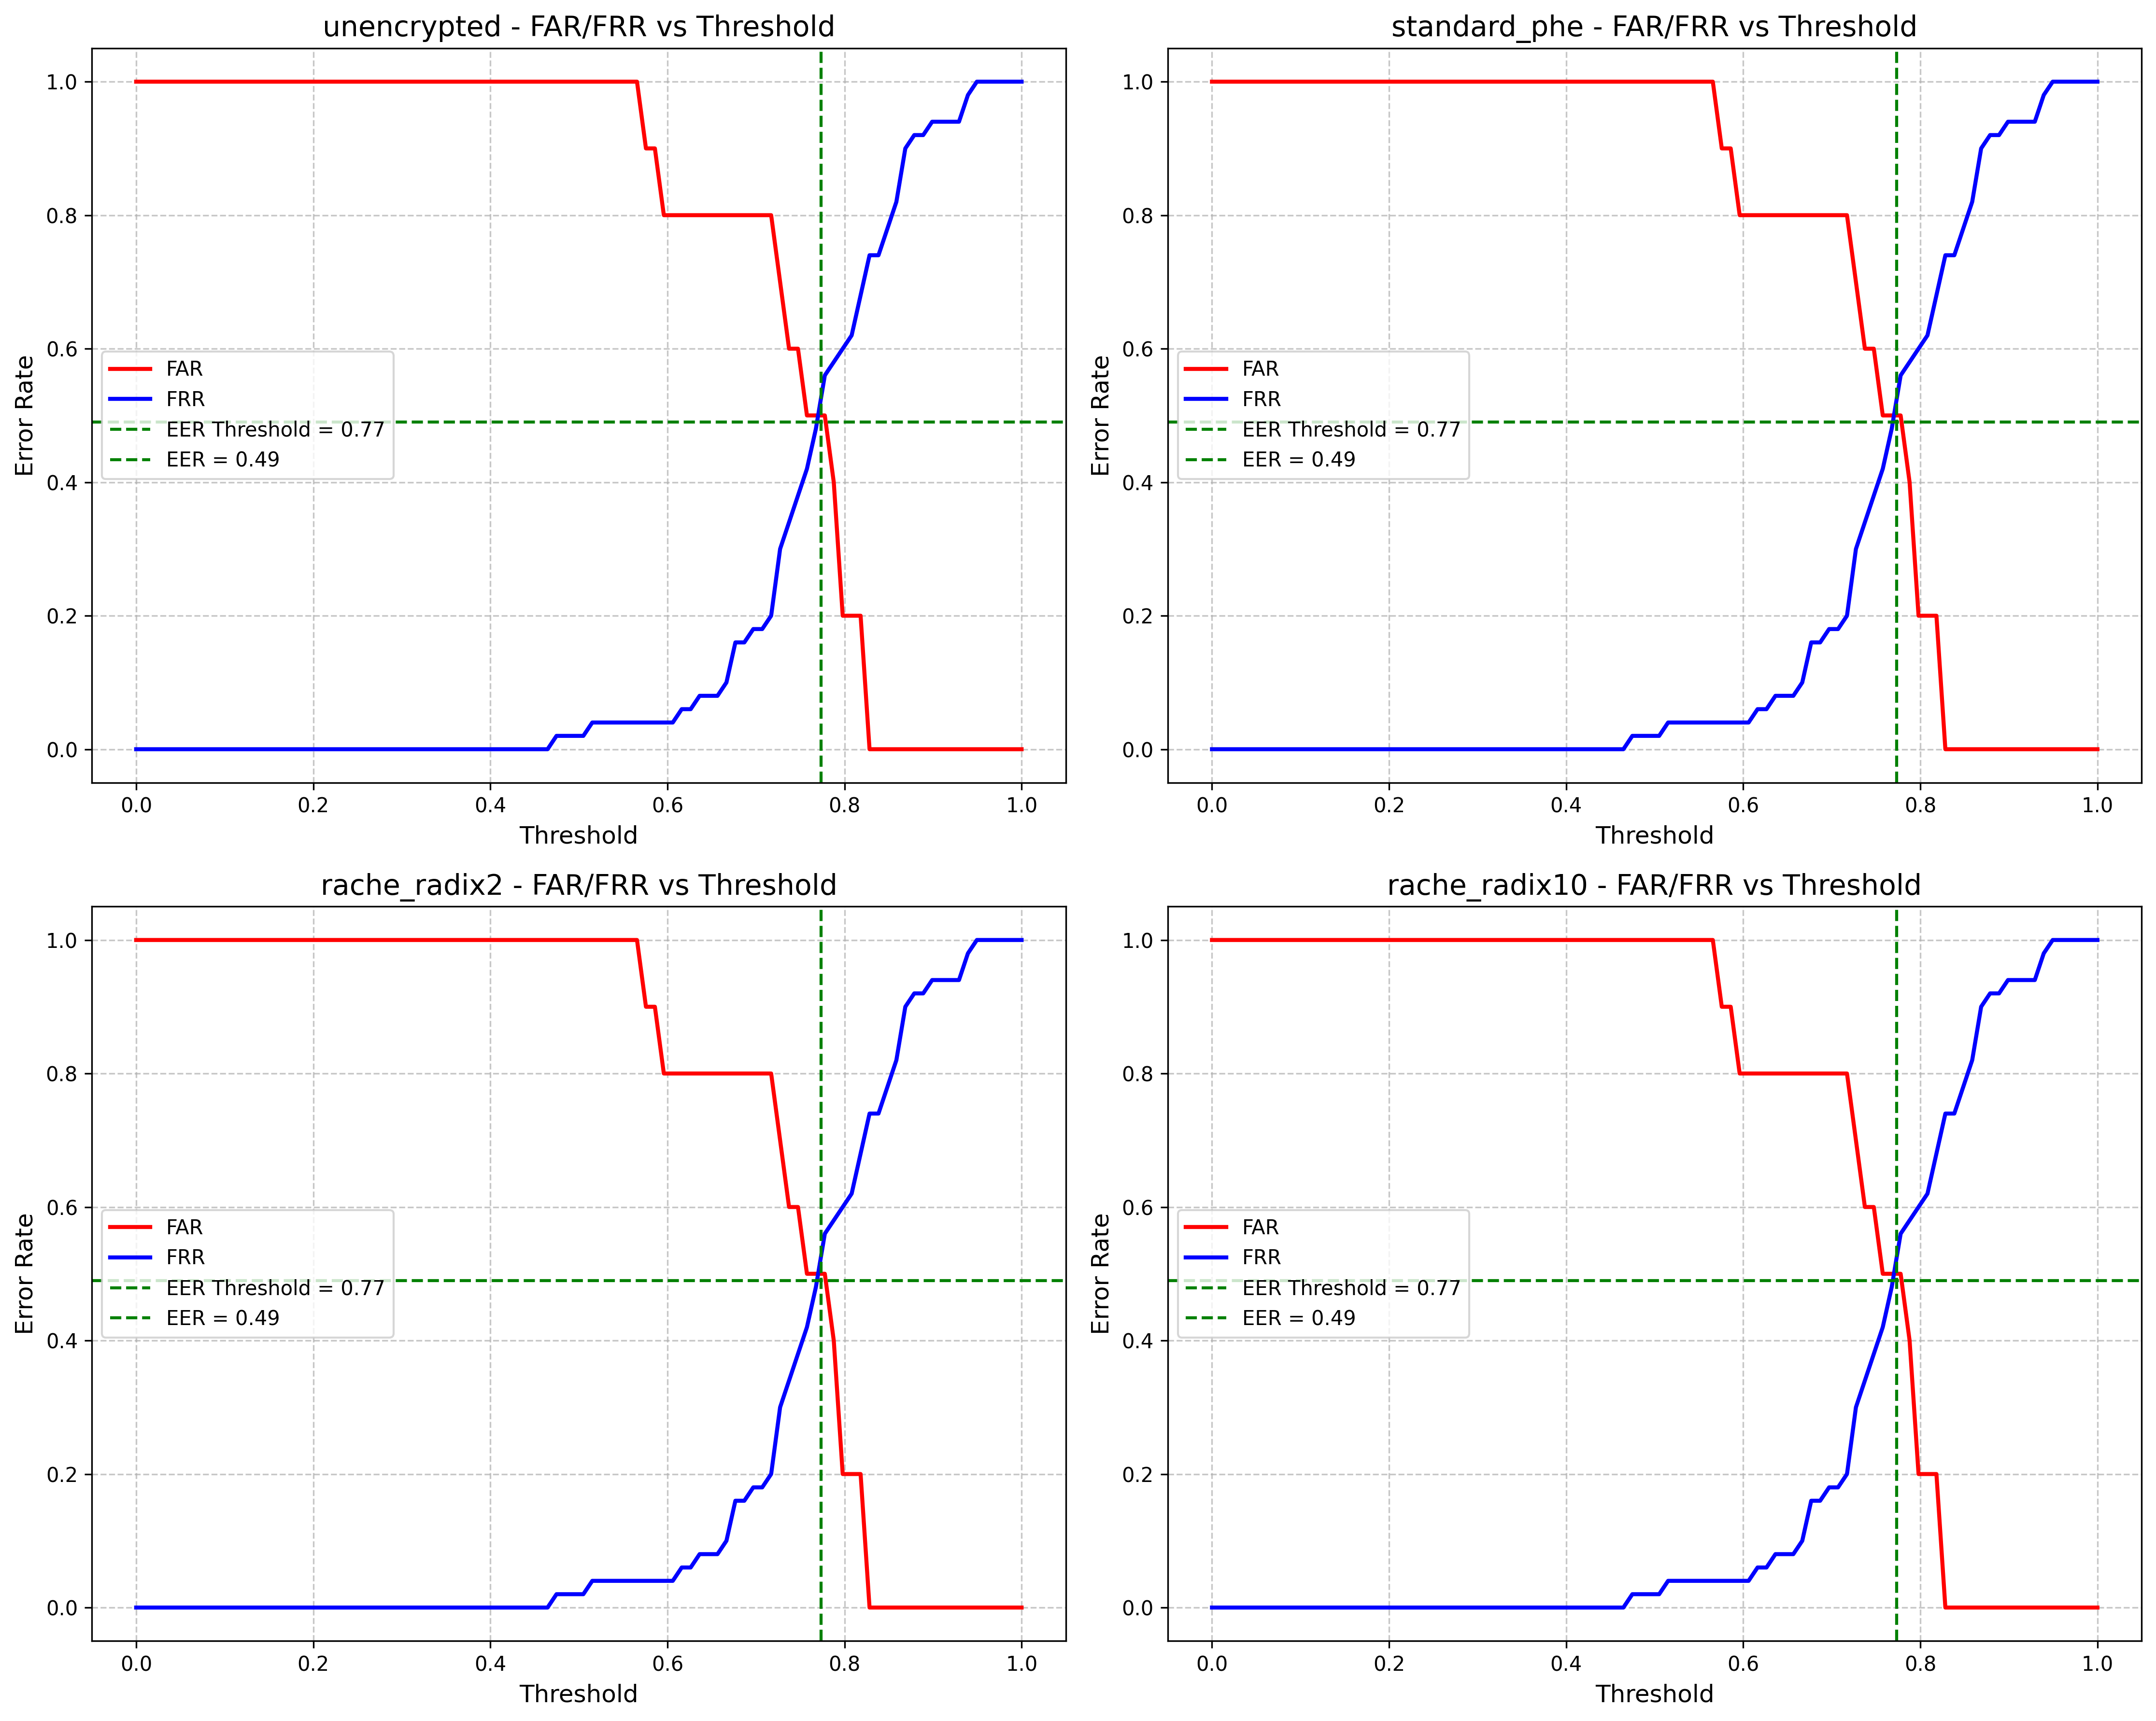


Performance Summary:
          Method   EER  EER Threshold  Feature Extraction Time (s)  \
0    unencrypted  0.49       0.773438                     0.232767   
1   standard_phe  0.49       0.773438                     0.053584   
2   rache_radix2  0.49       0.773438                     0.054217   
3  rache_radix10  0.49       0.773438                     0.051419   

   Comparison Time (s)  Total Time (s)  Genuine Samples  Impostor Samples  \
0             0.000026        0.232793               50                10   
1                  NaN        3.321714               50                10   
2                  NaN        2.489074               50                10   
3                  NaN        2.471904               50                10   

   Key Generation Time (s)  Encryption Time (s)  Matching Time (s)  \
0                      NaN                  NaN                NaN   
1                 0.172377             2.316863           0.943873   
2                 0.236941     

In [ ]:

!pip install fingerprint-feature-extractor phe opencv-python-headless matplotlib numpy pandas scikit-learn tqdm


from google.colab import drive
import os

def mount_drive_if_needed(expected_path):
    """Mounts Google Drive if the specified path doesn't exist"""
    if not os.path.exists(expected_path):
        print(f"Path {expected_path} not found. Mounting Google Drive...")
        drive.mount('/content/drive')

        # Check if the path exists after mounting
        if os.path.exists(expected_path):
            print(f"Successfully found {expected_path} after mounting Google Drive")
        else:
            print(f"Warning: {expected_path} still not found after mounting Google Drive")
            print("Please make sure the path is correct and the dataset is uploaded to your Google Drive")
    else:
        print(f"Path {expected_path} already exists")


fingerprint_dir = '/content/drive/MyDrive/praxisfiles/FVC2002/DB2_B'  # Default path if uploaded directly to Colab



mount_drive_if_needed(fingerprint_dir)

# Check if the directory contains fingerprint images
import glob

fingerprint_files = glob.glob(os.path.join(fingerprint_dir, '*.tif')) + \
                   glob.glob(os.path.join(fingerprint_dir, '*.jpg')) + \
                   glob.glob(os.path.join(fingerprint_dir, '*.png')) + \
                   glob.glob(os.path.join(fingerprint_dir, '*.bmp'))

if not fingerprint_files:
    print(f"No fingerprint images found in {fingerprint_dir}")
    print("Please make sure the FVC2002 DB2 dataset is correctly placed in this directory")
    print("Common FVC2002 fingerprint formats include .tif files")
else:
    print(f"Found {len(fingerprint_files)} fingerprint images in {fingerprint_dir}")

    # Display a sample image from the dataset
    import matplotlib.pyplot as plt
    import cv2

    sample_img = cv2.imread(fingerprint_files[0], cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(6, 8))
    plt.imshow(sample_img, cmap='gray')
    plt.title(f"Sample Fingerprint: {os.path.basename(fingerprint_files[0])}")
    plt.axis('off')
    plt.show()

    # List some of the fingerprint files for verification
    print("\nSample of fingerprint files:")
    for file in fingerprint_files[:10]:  # Show first 10 files
        print(f" - {os.path.basename(file)}")

    if len(fingerprint_files) > 10:
        print(f" ... and {len(fingerprint_files) - 10} more files")

# Run the benchmark on the FVC2002 dataset
print("\n============ RUNNING BENCHMARK ============\n")

# Import the benchmark class
from fvc2002_benchmark import FingerprintBenchmark

# Create a new output directory for the benchmark results
output_dir = 'fvc2002_benchmark_results'
os.makedirs(output_dir, exist_ok=True)

# Create the benchmark
benchmark = FingerprintBenchmark(fingerprint_dir, output_dir=output_dir)

# You can choose to run a quick benchmark with just the unencrypted method
# or the full benchmark with all methods

# Run quick benchmark (unencrypted only)
# print("\nRunning quick benchmark (unencrypted method only)...")
# benchmark.prepare_data(num_genuine=5, num_impostor=10)  # Use small numbers for faster execution
# benchmark.run_unencrypted_benchmark()
# benchmark.plot_far_frr_curves()
# benchmark.plot_score_distributions()
# benchmark.generate_performance_summary()

# Run full benchmark

print("\nRunning full benchmark (all methods)...")
benchmark.prepare_data(num_genuine=5, num_impostor=10)  # Use small numbers for faster execution
benchmark.run_full_benchmark()

print("\n============ BENCHMARK COMPLETE ============\n")

# Display the benchmark results directory
!ls -la {output_dir}/

# Display one of the generated plots
from IPython.display import Image, display
if os.path.exists(os.path.join(output_dir, 'far_frr_curves.png')):
    display(Image(os.path.join(output_dir, 'far_frr_curves.png')))

# Print performance summary
import pandas as pd
if os.path.exists(os.path.join(output_dir, 'performance_summary.csv')):
    summary_df = pd.read_csv(os.path.join(output_dir, 'performance_summary.csv'))
    print("\nPerformance Summary:")
    print(summary_df)